In [1]:
!pip install --extra-index-url https://download.pytorch.org/whl/cpu pandas numpy torch git+https://github.com/facebookincubator/flowtorch.git

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
  Cloning https://github.com/facebookincubator/flowtorch.git to /tmp/pip-req-build-ocwxd6ef
  Running command git clone --filter=blob:none --quiet https://github.com/facebookincubator/flowtorch.git /tmp/pip-req-build-ocwxd6ef
  Resolved https://github.com/facebookincubator/flowtorch.git to commit 2e773f2feb2b8e6f13b7d8795e4cd04321a6a5fa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


# Libs

In [2]:
import time

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
import flowtorch
import torch
from flowtorch import bijectors as B
from flowtorch import distributions as D
from flowtorch import parameters as P

In [6]:
print("torch: ", torch.__version__)

torch:  1.13.1+cpu


# GPU

In [7]:
torch.cuda.is_available()

False

# Functions

In [8]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [9]:
def plot_samples(dist, train_data, seed=1, ax=plt):
    set_seed(seed)
    N = train_data.shape[0]
    # Use the fitted distribution.
    start = time.time()
    samples = dist.sample((N,))
    end = time.time()
    print(f"sampling took {end-start} seconds.")

    df1 = pd.DataFrame(columns=["x1", "x2"], data=train_data)
    df1 = df1.assign(source="data")

    df2 = pd.DataFrame(columns=["x1", "x2"], data=samples.numpy())
    df2 = df2.assign(source="model")

    df = df1.append(df2, ignore_index=True)

    # sns.jointplot(data=df, x='x1', y='x2', hue='source', kind='kde')
    g = sns.jointplot(data=df, x="x1", y="x2", hue="source", ax=plt)
    g.plot_joint(sns.kdeplot, zorder=0)
    # g.plot_marginals(sns.rugplot, height=-.15)

## bernstein

In [10]:
def gen_basis(order, dtype=torch.float32):
    beta_dist = torch.distributions.Beta(
        torch.arange(1, order + 1, dtype=dtype)[...],
        torch.arange(order, 0, -1, dtype=dtype)[...],
    )

    def basis(x):
        log_prob = beta_dist.log_prob(x[..., None])
        return torch.exp(log_prob)

    return basis


def derive_thetas(thetas):
    theta_shape = thetas.shape
    order = theta_shape[-1]

    dtheta = (order - 1) * (thetas[..., 1:] - thetas[..., :-1])
    return dtheta


def get_end_points(thetas):
    return thetas[..., 0], thetas[..., -1]


def gen_bernstein_polynomial(thetas):
    thetas_shape = thetas.shape
    order = thetas_shape[-1]
    batch_shape = thetas_shape[:-1]

    basis = gen_basis(order, thetas.dtype)
    end_points = get_end_points(thetas)

    def bpoly(x):
        by = basis(torch.where((x > 0) & (x < 1), x, 0.5))
        y = torch.mean(by * thetas, axis=-1)
        y = torch.where(x == 0, end_points[0], y)
        y = torch.where(x == 1, end_points[1], y)
        y = torch.where((x >= 0) & (x <= 1), y, np.nan)

        return y

    return bpoly, order

## activation

In [11]:
def enshure_ordered_scaled(
    low=-4, high=4, constrain_second_drivative=False, fn=torch.nn.functional.softplus
):
    assert low < high, "low has to be smaller than high"

    def constrain_fn(diff):
        min_diff = torch.finfo(diff.dtype).resolution

        theta0 = low * torch.ones_like(diff[..., :1])

        diff_positive = fn(diff)

        if constrain_second_drivative:
            if constrain_second_drivative == "zero":
                low2 = diff_positive[..., :1]
                high2 = diff_positive[..., -1:]
            elif constrain_second_drivative == "turn":
                diff_positive = diff_positive[..., 1:-1]
                low2 = diff_positive[..., :1] + fn(diff[..., :1])
                high2 = diff_positive[..., -1:] + fn(diff[..., -1:])
            else:
                raise ValueError(
                    f'Unsupported value "{second_derivative}" for second_derivative'
                )
            diff_positive = torch.concat(
                (
                    low2,
                    diff_positive,
                    high2,
                ),
                axis=-1,
            )

        diff_positive /= diff_positive.sum(-1)[..., None]
        diff_positive *= high - low
        diff_positive += min_diff

        tc = torch.concat(
            (
                theta0,
                diff_positive,
            ),
            axis=-1,
        )
        thetas = torch.cumsum(tc, axis=-1)
        order = thetas.shape[-1]

        thetas_derivative = (order - 1) * diff_positive

        return thetas, thetas_derivative

    return constrain_fn

In [12]:
diff = torch.randn(10) * 10
print(diff)
# t,dt=enshure_ordered_scaled2(constrain_second_drivative='zero')(diff)
# t,dt,derive_thetas(dt)
thetas, thetas_derivative = enshure_ordered_scaled(constrain_second_drivative="zero")(
    diff
)
thetas, thetas_derivative, derive_thetas(thetas), derive_thetas(thetas_derivative)

tensor([ 5.5378, -1.8843,  5.1036,  0.3957, 25.1405, -5.0495, -7.5370,  7.3138,
        22.9296, -1.1075])


(tensor([-4.0000, -3.3944, -2.7888, -2.7734, -2.2150, -2.1155,  0.6318,  0.6325,
          0.6326,  1.4319,  3.9376,  3.9688,  4.0000]),
 tensor([7.2671e+00, 7.2671e+00, 1.8550e-01, 6.7006e+00, 1.1939e+00, 3.2968e+01,
         8.3943e-03, 7.1077e-04, 9.5918e+00, 3.0069e+01, 3.7437e-01, 3.7437e-01]),
 tensor([7.2671e+00, 7.2671e+00, 1.8550e-01, 6.7006e+00, 1.1939e+00, 3.2968e+01,
         8.3942e-03, 7.1096e-04, 9.5918e+00, 3.0069e+01, 3.7437e-01, 3.7437e-01]),
 tensor([ 0.0000e+00, -7.7897e+01,  7.1666e+01, -6.0573e+01,  3.4951e+02,
         -3.6255e+02, -8.4519e-02,  1.0550e+02,  2.2525e+02, -3.2664e+02,
          0.0000e+00]))

## Invert

In [13]:
def root_search_chandrupatla(
    objective_fn,
    initial_x,
    low=0.0,
    high=1.0,
    max_iterations=20,
    position_tolerance=1e-8,
    value_tolerance=0.0,
):
    F = objective_fn
    a = low * torch.zeros_like(initial_x)
    b = high * torch.ones_like(initial_x)
    f_a = F(a)
    f_b = F(b)
    t = 0.5
    itr = torch.zeros_like(initial_x)
    converged = torch.tensor(False)

    def step(a, b, f_a, f_b, t, itr, converged):
        """One step of Chandrupatla's method for root finding."""
        a_prev, b_prev, f_a_prev, f_b_prev, t_prev, itr_prev, converged_prev = (
            a,
            b,
            f_a,
            f_b,
            t,
            itr,
            converged,
        )
        finalized_elements = converged | (itr >= max_iterations)

        # Evaluate the new point.
        x_new = (1 - t) * a + t * b
        f_new = objective_fn(x_new)
        # If we've bisected (t==0.5) and the new float value for `a` is identical to
        # that from the previous iteration, then we'll keep bisecting (the
        # logic below will set t==0.5 for the next step), and nothing further will
        # change.
        at_fixed_point = (x_new == a) & (t == 0.5)
        # Otherwise, tighten the bounds.
        cond = torch.sign(f_new) == torch.sign(f_a)
        a = x_new
        f_a = f_new
        b = torch.where(cond, b, a_prev)
        f_b = torch.where(cond, f_b, f_a)
        c = torch.where(cond, a_prev, b_prev)
        f_c = torch.where(cond, f_a, f_b)

        # Check for convergence.
        f_best = torch.where(torch.abs(f_a) < torch.abs(f_b), f_a, f_b)
        interval_tolerance = position_tolerance / (torch.abs(b - c))
        converged = (interval_tolerance > 0.5) | (
            (torch.abs(f_best) <= value_tolerance) | (at_fixed_point)
        )

        # Propose next point to evaluate.
        xi = (a - b) / (c - b)
        phi = (f_a - f_b) / (f_c - f_b)
        t = torch.where(
            # Condition for inverse quadratic interpolation.
            (1 - torch.sqrt(1 - xi) < phi) & (torch.sqrt(xi) > phi),
            # Propose a point by inverse quadratic interpolation.
            (
                f_a / (f_b - f_a) * f_c / (f_b - f_c)
                + (c - a) / (b - a) * f_a / (f_c - f_a) * f_b / (f_c - f_b)
            ),
            # Otherwise, just cut the interval in half (bisection).
            0.5,
        )

        # Constrain the proposal to the current interval (0 < t < 1).
        t = torch.minimum(torch.maximum(t, interval_tolerance), 1 - interval_tolerance)

        a = torch.where(finalized_elements, a_prev, a)
        b = torch.where(finalized_elements, b_prev, b)
        f_a = torch.where(finalized_elements, f_a_prev, f_a)
        f_b = torch.where(finalized_elements, f_b_prev, f_b)
        t = torch.where(finalized_elements, t_prev, t)
        itr = torch.where(finalized_elements, itr_prev, itr + 1)
        converged = torch.where(finalized_elements, converged_prev, converged)

        return a, b, f_a, f_b, t, itr + 1, converged

    while torch.all(itr < max_iterations) and not converged.all():
        a, b, f_a, f_b, t, itr, converged = step(a, b, f_a, f_b, t, itr, converged)

    cond = torch.abs(f_a) < torch.abs(f_b)
    estimated_root = torch.where(cond, a, b)
    err = torch.where(cond, torch.abs(f_a), torch.abs(f_a))

    return estimated_root, err, itr

In [14]:
from functools import partial


def aprox_bpoly_inv(
    bpoly, y, max_iterations=100, domain_constraint_fn=partial(torch.clip, min=0, max=1)
):

    x, err, itr = root_search_chandrupatla(
        lambda x: bpoly(domain_constraint_fn(x)) - y,
        0.5 * torch.ones_like(y),
        position_tolerance=torch.finfo(y.dtype).resolution,
        max_iterations=max_iterations,
    )
    x = domain_constraint_fn(x)
    return torch.where(itr <= max_iterations, x, np.nan)

## Extrapolation

In [15]:
def gen_linear_extansion(thetas):
    # y = x + b

    # [Be(0),Be(1)]
    end_values = get_end_points(thetas)

    # b = Be
    b = torch.stack(end_values)

    def extra(x_or_y, invert=False):

        if invert:
            y = x_or_y
            x = np.nan * torch.ones_like(y)

            x0 = y - b[0]
            x1 = y + 1 - b[1]

            x = torch.where((x0 <= 0), x0, x)
            x = torch.where((x1 >= 1), x1, x)

            return x
        else:
            x = x_or_y
            y = np.nan * torch.ones_like(x)

            y0 = x + b[0]
            y1 = x - 1 + b[1]

            y = torch.where(x <= 0, y0, y)
            y = torch.where(x >= 1, y1, y)

            return y

    def extra_grad(x):
        y = np.nan * torch.ones_like(x)

        y = torch.where(x <= 0, 1.0, y)
        y = torch.where(x >= 1, 1.0, y)

        return y

    return extra, extra_grad


def gen_linear_extrapolation(thetas):
    # y = a * x + b
    # y' = a

    # [Be(0),Be(1)]
    end_values = get_end_points(thetas)

    # [Be'(0),Be'(1)]
    dtheta = derive_thetas(thetas)
    first_derivative_end_values = get_end_points(dtheta)

    # a = b' = Be'
    a = torch.stack(first_derivative_end_values)

    # b = y - a = Be - a
    b = torch.stack(end_values) - a

    def extra(x_or_y, invert=False):

        if invert:
            y = x_or_y
            x = np.nan * torch.ones_like(y)

            x0 = (y - b[0]) / a[0] - 1
            x1 = (y - b[1]) / a[1]

            x = torch.where((x0 <= 0), x0, x)
            x = torch.where((x1 >= 1), x1, x)

            return x
        else:
            x = x_or_y
            y = np.nan * torch.ones_like(x)

            y0 = a[0] * (x + 1) + b[0]
            y1 = a[1] * x + b[1]

            y = torch.where(x <= 0, y0, y)
            y = torch.where(x >= 1, y1, y)

            return y

    def extra_grad(x):
        y = np.nan * torch.ones_like(x)

        y = torch.where(x <= 0, a[0], y)
        y = torch.where(x >= 1, a[1], y)

        return y

    return extra, extra_grad


def gen_quadratic_extrapolation(thetas):
    # y= ax^2 + bx + c
    # [Be(0),Be(1)]
    end_values = torch.stack(get_end_points(thetas))

    # [Be'(0),Be'(1)]
    dtheta = derive_thetas(thetas)
    first_derivative_end_values = torch.stack(get_end_points(dtheta))

    # [Be''(0),Be''(1)]
    dtheta = derive_thetas(dtheta)
    second_derivative_end_values = torch.stack(get_end_points(dtheta))

    # a = y''/2
    a = second_derivative_end_values / 2

    # b = y'-2a
    b = first_derivative_end_values - 2 * a

    # c = y - a -b
    c = end_values - a - b

    def extra(x_or_y, invert=False):

        if invert:
            y = x_or_y
            x = np.nan * torch.ones_like(y)

            x0 = (-b[0] + torch.sqrt(-4 * a[0] * c[0] + 4 * a[0] * y + b[0] ** 2)) / (
                2 * a[0]
            ) - 1
            x1 = (-b[1] + torch.sqrt(-4 * a[1] * c[1] + 4 * a[1] * y + b[1] ** 2)) / (
                2 * a[1]
            )

            x = torch.where((x0 <= 0), x0, x)
            x = torch.where((x1 >= 1), x1, x)

            return x
        else:
            x = x_or_y
            y = np.nan * torch.ones_like(x)

            y0 = a[0] * (x + 1) ** 2 + b[0] * (x + 1) + c[0]
            y1 = a[1] * x**2 + b[1] * x + c[1]

            y = torch.where(x <= 0, y0, y)
            y = torch.where(x >= 1, y1, y)

            return y

    def extra_grad(x):
        y = np.nan * torch.ones_like(x)
        e0 = 2 * a[0] * (x + 1) + b[0]
        e1 = 2 * a[1] * x + b[1]

        y = torch.where(x <= 0, e0, y)
        y = torch.where(x >= 1, e1, y)

        return y

    return extra, extra_grad

In [16]:
def gen_bernstein_polynomial_with_extrapolation(
    thetas, dthetas=None, gen_extrapolation_fn=gen_linear_extrapolation
):
    bpoly, order = gen_bernstein_polynomial(thetas)
    if dthetas is None:
        dthetas = derive_thetas(thetas)
    bpoly_grad, _ = gen_bernstein_polynomial(dthetas)
    extra, extra_grad = gen_extrapolation_fn(thetas)

    ep = get_end_points(thetas)

    def bpoly_extra(x_or_y, invert=False):
        if invert:
            y = x_or_y
            y = torch.as_tensor(y)
            x = aprox_bpoly_inv(bpoly, y)
            e = extra(y, True)
            x = torch.where((y < ep[0]) | (y > ep[1]), e, x)
            return x
        else:
            x = x_or_y
            x = torch.as_tensor(x)
            y = bpoly(torch.where((x < 0) | (x > 1), 0.5, x))
            y = torch.where((x <= 0) | (x >= 1), extra(x), y)
            return y

    def bpoly_grad_extra(x):
        x = torch.as_tensor(x)
        y = bpoly_grad(torch.where((x < 0) | (x > 1), 0.5, x))
        y = torch.where((x <= 0) | (x >= 1), extra_grad(x), y)
        return y

    return bpoly_extra, bpoly_grad_extra, order


def gen_bernstein_polynomial_with_linear_extension(*args):
    return gen_bernstein_polynomial_with_extrapolation(
        *args, gen_extrapolation_fn=gen_linear_extansion
    )


def gen_bernstein_polynomial_with_linear_extrapolation(*args):
    return gen_bernstein_polynomial_with_extrapolation(
        *args, gen_extrapolation_fn=gen_linear_extrapolation
    )


def gen_bernstein_polynomial_with_quadratic_extrapolation(*args):
    return gen_bernstein_polynomial_with_extrapolation(
        *args, gen_extrapolation_fn=gen_quadratic_extrapolation
    )

# Tests

In [17]:
set_seed(1)

In [18]:
pv = torch.rand((10,), dtype=torch.float64, requires_grad=True)
bpoly, order = gen_bernstein_polynomial(enshure_ordered_scaled()(pv)[0])

In [19]:
torch.autograd.gradcheck(enshure_ordered_scaled(), pv)

True

In [20]:
x = torch.rand((10,), dtype=torch.float64, requires_grad=True)
torch.autograd.gradcheck(bpoly, x)
torch.autograd.gradgradcheck(bpoly, x)

True

In [21]:
def bpoly_forward(pv, x, **kwds):
    bpoly, bpoly_grad, order = gen_bernstein_polynomial_with_extrapolation(
        *enshure_ordered_scaled()(pv), **kwds
    )
    return bpoly(x), bpoly_grad(x)

In [22]:
with torch.autograd.profiler.profile() as prof:
    torch.autograd.gradcheck(bpoly_forward, (pv, x))

STAGE:2023-03-21 17:46:50 14358:14358 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-03-21 17:46:51 14358:14358 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [23]:
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::where        10.60%       7.549ms        15.46%      11.016ms       5.443us          2024  
                                              aten::sum         6.56%       4.672ms         7.07%       5.034ms       5.538us           909  
                                         aten::_to_copy         5.78%       4.119ms         7.52%       5.355ms       3.154us          1698  
                                              aten::mul         5.51%       3.925ms         7.47%       5.321ms       5.867us           907  
      

# Plots

In [24]:
gen_bp_fns = [
    # gen_bernstein_polynomial,
    gen_bernstein_polynomial_with_linear_extension,
    gen_bernstein_polynomial_with_linear_extrapolation,
    gen_bernstein_polynomial_with_quadratic_extrapolation,
]

In [25]:
gen_extra_fns = [
    gen_linear_extansion,
    gen_linear_extrapolation,
    gen_quadratic_extrapolation,
]

In [26]:
constrain_fns = [
    enshure_ordered_scaled(),
    enshure_ordered_scaled(constrain_second_drivative="zero"),
    enshure_ordered_scaled(constrain_second_drivative="turn"),
]

## Extrapolation

/tmp/ipykernel_14358/3542949589.py:23: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  mse_grad = torch.mean(((grad - grad2) ** 2)[~np.isnan(grad) & ~np.isnan(grad2)])


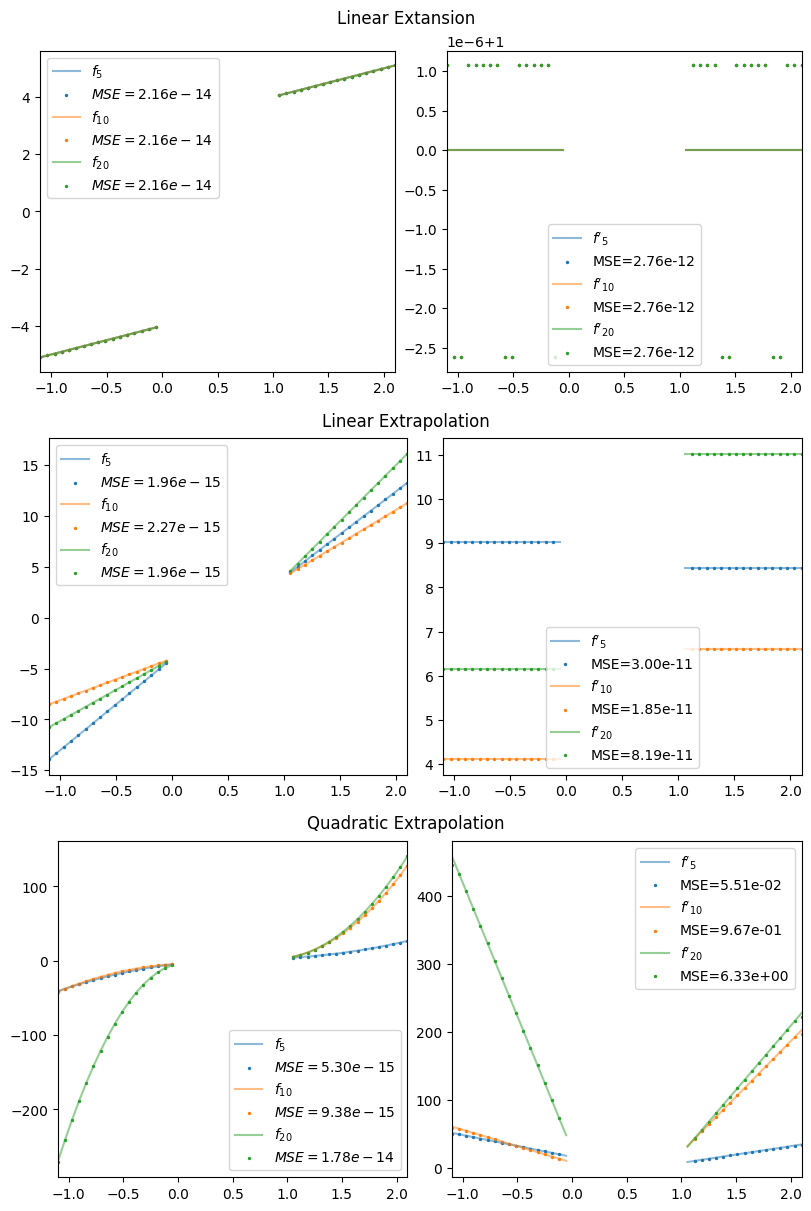

In [27]:
xlim = (-1.1, 2.1)
x = torch.linspace(*xlim, 50, dtype=torch.float32)
# https://matplotlib.org/3.5.0/tutorials/intermediate/gridspec.html#basic-quickstart-guide
fig = plt.figure(figsize=(8, 12), constrained_layout=True)
specs = gridspec.GridSpec(ncols=1, nrows=len(gen_bp_fns), figure=fig)
for spec, (fn, c_fn) in zip(specs, zip(gen_extra_fns, constrain_fns)):
    subfig = fig.add_subfigure(spec)
    ax = subfig.subplots(nrows=1, ncols=2)
    np.random.seed(1)
    for M in [5, 10, 20]:
        subfig.suptitle(fn.__name__.replace("_", " ").title()[4:])

        theta = torch.randn((1, M))
        extra, grad_extra = fn(c_fn(theta)[0])

        y = extra(x)
        xx = extra(y, True)
        mse_x = torch.mean(((x - xx) ** 2)[~torch.isnan(xx)])

        grad = grad_extra(x)

        grad2 = np.gradient(y, np.diff(x).mean())
        mse_grad = torch.mean(((grad - grad2) ** 2)[~np.isnan(grad) & ~np.isnan(grad2)])

        ax[0].plot(x, y, alpha=0.5, label=f"$f_{{{M}}}$")
        ax[0].scatter(xx, y, s=2, label=f"$MSE={mse_x:.2e}$")
        ax[0].set_xlim(*xlim)
        ax[0].legend()
        ax[1].plot(x, grad, alpha=0.5, label=f"$f'_{{{M}}}$")
        ax[1].scatter(x, grad2, s=2, label=f"MSE={mse_grad:.2e}")
        ax[1].legend()
        ax[1].set_xlim(*xlim)

## Unconstrained

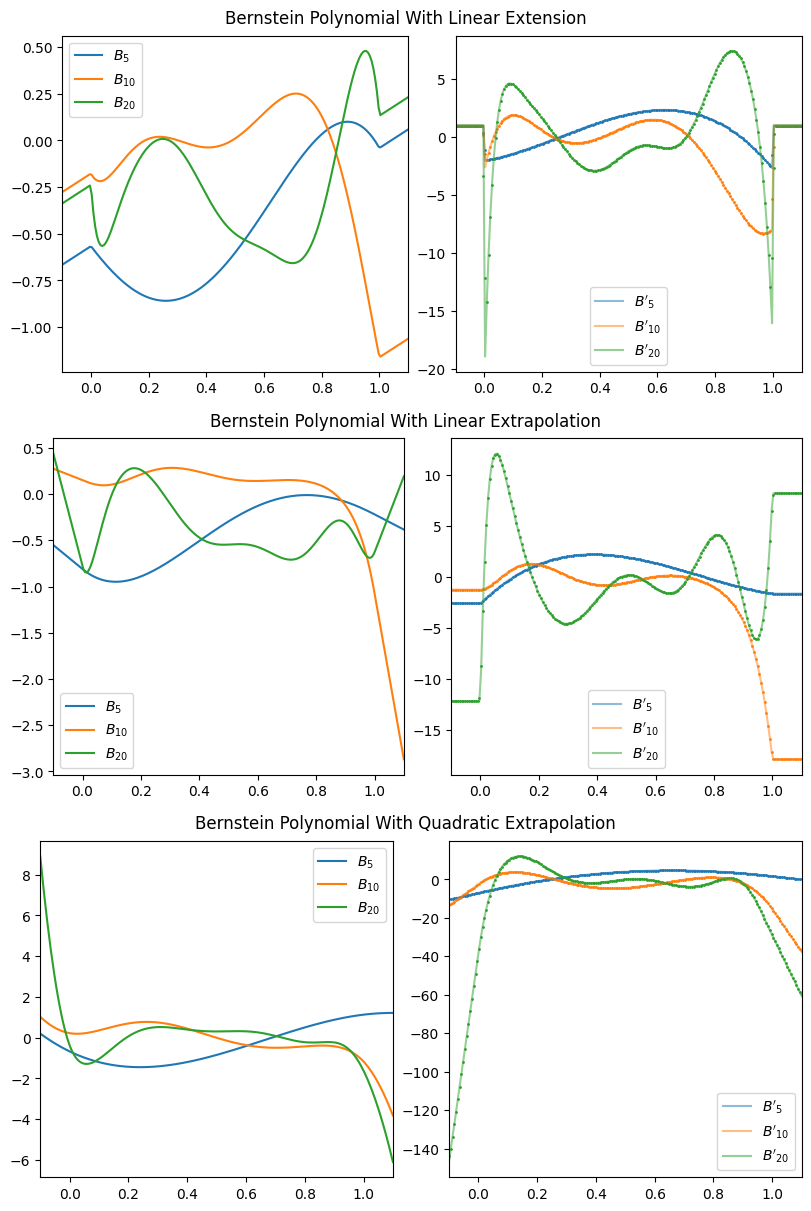

In [28]:
xlim = (-0.1, 1.1)
x = torch.linspace(*xlim, 200, dtype=torch.float32)

# https://matplotlib.org/3.5.0/tutorials/intermediate/gridspec.html#basic-quickstart-guide
fig = plt.figure(figsize=(8, 12), constrained_layout=True)
specs = gridspec.GridSpec(ncols=1, nrows=len(gen_bp_fns), figure=fig)
for spec, fn in zip(specs, gen_bp_fns):
    subfig = fig.add_subfigure(spec)
    ax = subfig.subplots(nrows=1, ncols=2)
    np.random.seed(1)
    for M in [5, 10, 20]:
        subfig.suptitle(fn.__name__.replace("_", " ").title()[4:])

        thetas = torch.randn((1, M))
        bpoly, bpoly_grad, order = fn(thetas)

        y = bpoly(x)
        grad = bpoly_grad(x)
        grad2 = np.gradient(y, np.diff(x).mean())

        ax[0].plot(x, y, label=f"$B_{{{M}}}$")
        ax[0].legend()
        ax[0].set_xlim(*xlim)
        ax[1].plot(x, grad, alpha=0.5, label=f"$B'_{{{M}}}$")
        ax[1].scatter(x, grad2, s=1)
        ax[1].legend()
        ax[1].set_xlim(*xlim)

## Constrained

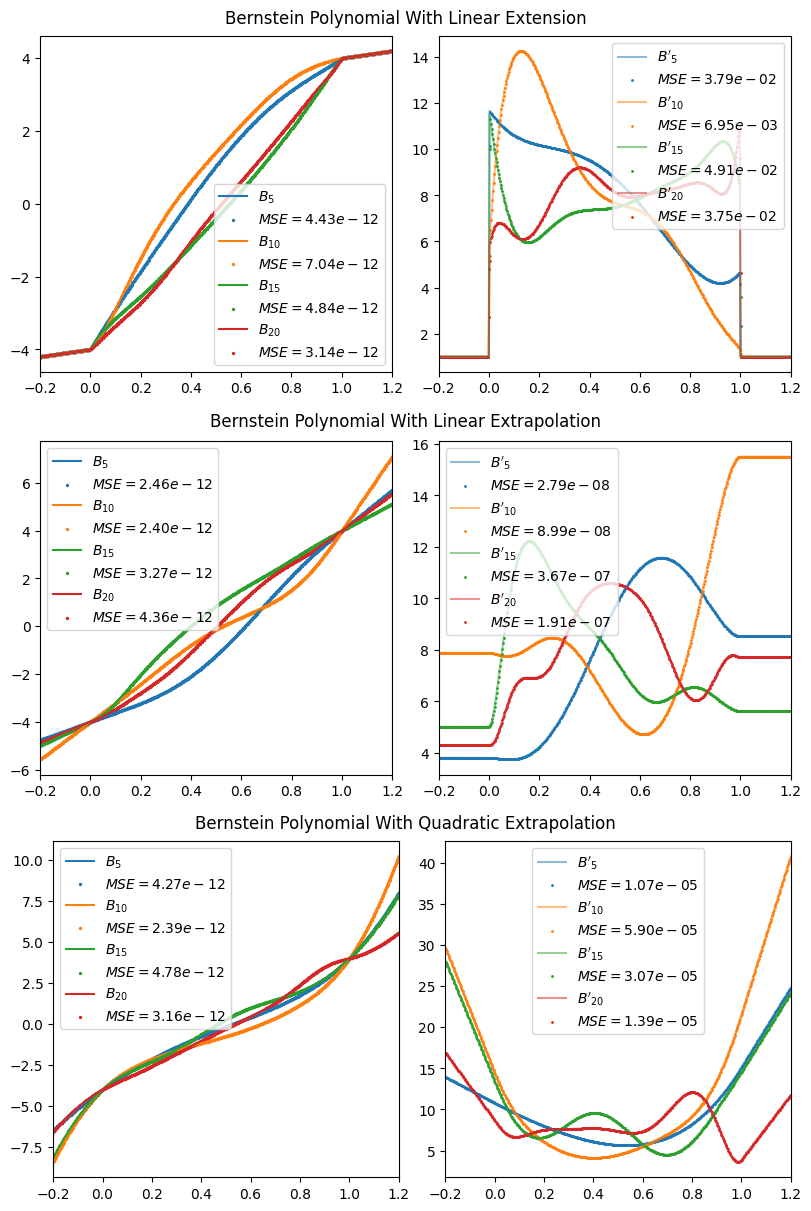

In [29]:
xlim = (-0.2, 1.2)
x = torch.linspace(*xlim, 500, dtype=torch.float32)

# https://matplotlib.org/3.5.0/tutorials/intermediate/gridspec.html#basic-quickstart-guide
fig = plt.figure(figsize=(8, 12), constrained_layout=True)
specs = gridspec.GridSpec(ncols=1, nrows=len(gen_bp_fns), figure=fig)
for spec, (fn, c_fn) in zip(specs, zip(gen_bp_fns, constrain_fns)):
    subfig = fig.add_subfigure(spec)
    ax = subfig.subplots(nrows=1, ncols=2)
    np.random.seed(1)
    for M in [5, 10, 15, 20]:
        subfig.suptitle(fn.__name__.replace("_", " ").title()[4:])

        theta = torch.randn((1, M))
        bpoly, bpoly_grad, order = fn(*c_fn(theta))

        y = bpoly(x)
        xx = bpoly(y, True)
        mse_x = torch.mean(((x - xx) ** 2))

        grad = bpoly_grad(x)
        grad2 = np.gradient(y, np.diff(x).mean())
        mse_grad = torch.mean(((grad - grad2) ** 2))

        ax[0].plot(x, y, label=f"$B_{{{M}}}$")
        ax[0].scatter(xx, y, s=2, label=f"$MSE={mse_x:.2e}$")
        ax[0].legend()
        ax[0].set_xlim(*xlim)
        ax[1].plot(x, grad, alpha=0.5, label=f"$B'_{{{M}}}$")
        ax[1].scatter(x, grad2, s=1, label=f"$MSE={mse_grad:.2e}$")
        ax[1].legend()
        ax[1].set_xlim(*xlim)

# Bijector

In [30]:
from typing import Any, Callable, Optional, Sequence, Tuple

import flowtorch
import torch
import torch.nn.functional as F
from flowtorch.bijectors.base import Bijector
from flowtorch.ops import monotonic_rational_spline
from torch.distributions.utils import _sum_rightmost


class BernsteinPolynomialOP(Bijector):
    def __init__(
        self,
        params_fn: Optional[flowtorch.Lazy] = None,
        *,
        shape: torch.Size,
        context_shape: Optional[torch.Size] = None,
        order: int = 10,
        extrapolation: str = None,
        thetas_constraint_fn: Callable = None
    ) -> None:
        if extrapolation not in [None, "linear", "quadratic"]:
            raise ValueError(
                "Keyword argument 'extrapolation' must be one of [None, 'linear', \
'quadratic'], but '{}' was found!".format(
                    extrapolation
                )
            )

        self.order = order
        self.thetas_constraint_fn = thetas_constraint_fn

        if extrapolation == "linear":
            self.gen_bpoly_fn = gen_bernstein_polynomial_with_linear_extrapolation
            if self.thetas_constraint_fn is None:
                self.thetas_constraint_fn = enshure_ordered_scaled(
                    constrain_second_drivative="zero"
                )
        elif extrapolation == "quadratic":
            self.gen_bpoly_fn = gen_bernstein_polynomial_with_quadratic_extrapolation
            if self.thetas_constraint_fn is None:
                self.thetas_constraint_fn = enshure_ordered_scaled(
                    constrain_second_drivative="turn"
                )
        else:
            self.gen_bpoly_fn = gen_bernstein_polynomial_with_linear_extension
            if self.thetas_constraint_fn is None:
                self.thetas_constraint_fn = enshure_ordered_scaled()

        super().__init__(params_fn, shape=shape, context_shape=context_shape)

    def _inverse(
        self, y: torch.Tensor, params: Optional[Sequence[torch.Tensor]]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        thetas = self.thetas_constraint_fn(*params)
        bpoly, bpoly_grad, _ = self.gen_bpoly_fn(*thetas)
        x = bpoly(y)
        ladj = -torch.log(bpoly_grad(y))
        return x, _sum_rightmost(ladj, self.domain.event_dim)

    def _forward(
        self, x: torch.Tensor, params: Optional[Sequence[torch.Tensor]]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        thetas = self.thetas_constraint_fn(*params)
        bpoly, bpoly_grad, _ = self.gen_bpoly_fn(*thetas)
        y = bpoly(x, True)
        ladj = -torch.log(bpoly_grad(y))
        return y, _sum_rightmost(ladj, self.domain.event_dim)

    def _log_abs_det_jacobian(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
        params: Optional[Sequence[torch.Tensor]],
    ) -> torch.Tensor:
        thetas = self.thetas_constraint_fn(*params)
        _, bpoly_grad, _ = self.gen_bpoly_fn(*thetas)
        ladj = torch.log(bpoly_grad(x))
        return _sum_rightmost(ladj, self.domain.event_dim)

    def param_shapes(self, shape: torch.Size) -> Sequence[torch.Size]:
        shape = torch.Size((shape + (self.order,)))
        return (shape,)

In [31]:
from typing import Optional

import flowtorch
import torch
from flowtorch.bijectors import Autoregressive, Elementwise, Invert


class BernsteinPolynomial(BernsteinPolynomialOP, Elementwise):
    def __init__(
        self,
        params_fn: Optional[flowtorch.Lazy] = None,
        *,
        shape: torch.Size,
        context_shape: Optional[torch.Size] = None,
        order: int = 10,
        extrapolation: str = None,
        thetas_constraint_fn: Callable = None
    ) -> None:
        super().__init__(
            params_fn=params_fn,
            shape=shape,
            context_shape=context_shape,
            order=order,
            extrapolation=extrapolation,
            thetas_constraint_fn=thetas_constraint_fn,
        )


class BernsteinPolynomialAutoregressive(BernsteinPolynomialOP, Autoregressive):
    def __init__(
        self,
        params_fn: Optional[flowtorch.Lazy] = None,
        *,
        shape: torch.Size,
        context_shape: Optional[torch.Size] = None,
        order: int = 10,
        extrapolation: str = None,
        thetas_constraint_fn: Callable = None
    ) -> None:
        super().__init__(
            params_fn=params_fn,
            shape=shape,
            context_shape=context_shape,
            order=order,
            extrapolation=extrapolation,
            thetas_constraint_fn=thetas_constraint_fn,
        )

In [32]:
def gen_flow(bij):
    event_dim = max(bij.domain.event_dim, 1)
    event_shape = event_dim * [3]
    base_dist = torch.distributions.Independent(
        torch.distributions.Normal(torch.zeros(event_shape), torch.ones(event_shape)),
        event_dim,
    )

    flow = D.Flow(base_dist, bij)
    return flow


def test_jacobian(flow, epsilon=1e-2):
    # Instantiate transformed distribution and parameters
    bij = flow.bijector
    params = bij._params_fn

    # Calculate auto-diff Jacobian
    x = torch.randn(*flow.event_shape)
    x = torch.distributions.transform_to(bij.domain)(x)
    y = bij.forward(x)
    if bij.domain.event_dim == 1:
        analytic_ldt = bij.log_abs_det_jacobian(x, y).data
    else:
        analytic_ldt = bij.log_abs_det_jacobian(x, y).sum(-1).data

    # Calculate numerical Jacobian
    # TODO: Better way to get all indices of array/tensor?
    jacobian = torch.zeros(flow.event_shape * 2)
    idxs = np.nonzero(np.ones(flow.event_shape))

    # Have to permute elements for MADE
    count_vars = len(idxs[0])
    if hasattr(params, "permutation"):
        inv_permutation = np.zeros(count_vars, dtype=int)
        inv_permutation[params.permutation] = np.arange(count_vars)

    # TODO: Vectorize numerical calculation of Jacobian with PyTorch
    # TODO: Break this out into flowtorch.numerical.derivatives.jacobian
    for var_idx in range(count_vars):
        idx = [dim_idx[var_idx] for dim_idx in idxs]
        epsilon_vector = torch.zeros(flow.event_shape)
        epsilon_vector[(*idx,)] = epsilon
        # TODO: Use scipy.misc.derivative or another library's function?
        delta = (
            bij.forward(x + 0.5 * epsilon_vector)
            - bij.forward(x - 0.5 * epsilon_vector)
        ) / epsilon

        for var_jdx in range(count_vars):
            jdx = [dim_jdx[var_jdx] for dim_jdx in idxs]

            # Have to account for permutation potentially introduced by MADE network
            # TODO: Make this more general with structure abstraction
            if hasattr(params, "permutation"):
                jacobian[(inv_permutation[idx[0]], inv_permutation[jdx[0]])] = float(
                    delta[(Ellipsis, *jdx)].data.sum()
                )
            else:
                jacobian[(*idx, *jdx)] = float(delta[(Ellipsis, *jdx)].data.sum())

    # For autoregressive flow, Jacobian is sum of diagonal, otherwise need full
    # determinate
    if hasattr(params, "permutation"):
        print("permutation")
        numeric_ldt = torch.sum(torch.log(torch.diag(jacobian)))
    else:
        numeric_ldt = torch.log(torch.abs(jacobian.det()))

    ldt_discrepancy = (analytic_ldt - numeric_ldt).abs()
    assert ldt_discrepancy < epsilon, f"{analytic_ldt} != {numeric_ldt}"

    # Test that lower triangular with non-zero diagonal for autoregressive flows
    if hasattr(params, "permutation"):
        print("autoregressive")

        def nonzero(x):
            return torch.sign(torch.abs(x))

        diag_sum = torch.sum(torch.diag(nonzero(jacobian)))
        lower_sum = torch.sum(torch.tril(nonzero(jacobian), diagonal=-1))
        assert diag_sum == float(count_vars)
        assert lower_sum == float(0.0)


def test_inverse(flow, epsilon=1e-5):
    bij = flow.bijector
    base_dist = flow.base_dist

    # Test g^{-1}(g(x)) = x
    x_true = base_dist.sample(torch.Size([10]))
    x_true = torch.distributions.transform_to(bij.domain)(x_true)

    y = bij.forward(x_true)
    J_1 = y.log_detJ
    y = y.detach_from_flow()

    x_calculated = bij.inverse(y)
    J_2 = x_calculated.log_detJ
    x_calculated = x_calculated.detach_from_flow()

    assert (x_true - x_calculated).abs().max().item() < epsilon

    # Test that Jacobian after inverse op is same as after forward
    assert (J_1 - J_2).abs().max().item() < epsilon, f"{J_1}, {J_2}"

In [33]:
set_seed(1)
test_jacobian(gen_flow(BernsteinPolynomial), epsilon=1e-2)
test_inverse(gen_flow(BernsteinPolynomial), epsilon=1e-5)

test_jacobian(gen_flow(BernsteinPolynomialAutoregressive), epsilon=1e-2)
test_inverse(gen_flow(BernsteinPolynomialAutoregressive), epsilon=1e-4)

permutation
autoregressive


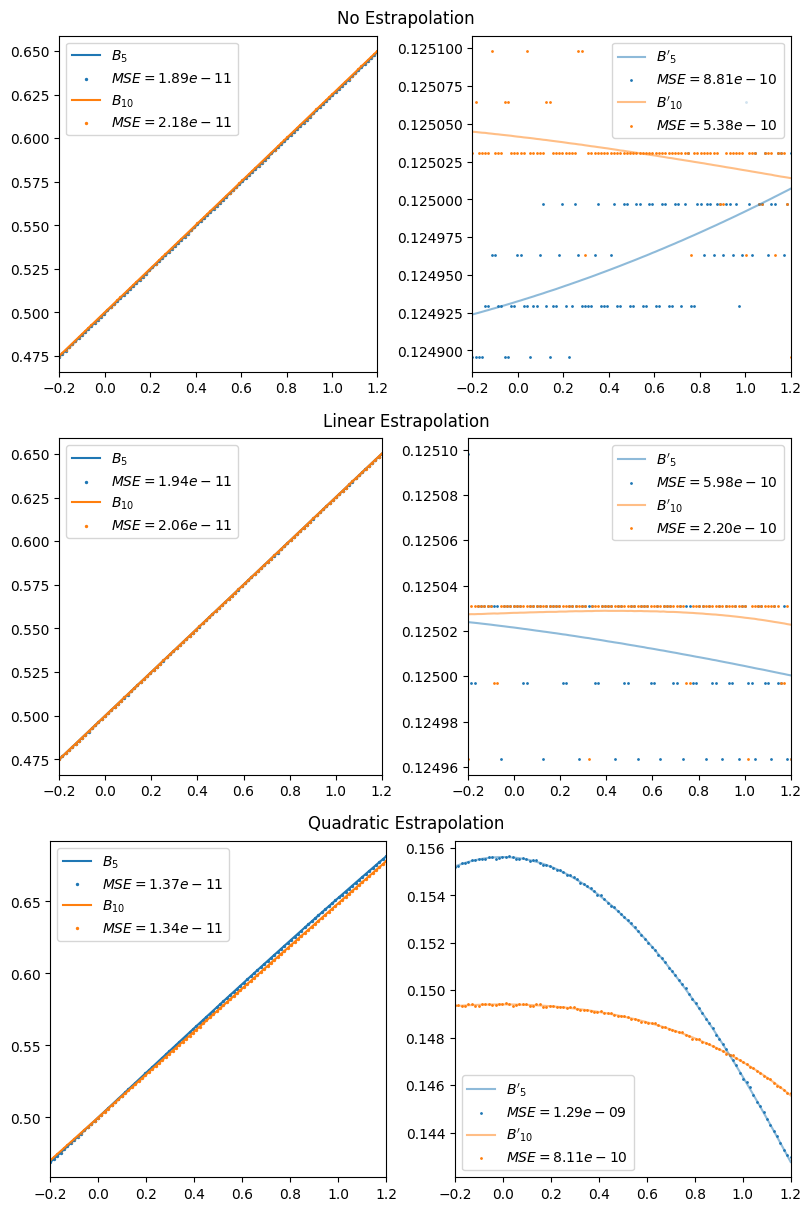

In [34]:
xlim = (-0.2, 1.2)
x = torch.linspace(*xlim, 100, dtype=torch.float32)

# https://matplotlib.org/3.5.0/tutorials/intermediate/gridspec.html#basic-quickstart-guide
fig = plt.figure(figsize=(8, 12), constrained_layout=True)
extra = [None, "linear", "quadratic"]
specs = gridspec.GridSpec(ncols=1, nrows=len(extra), figure=fig)
for spec, e in zip(specs, extra):
    subfig = fig.add_subfigure(spec)
    ax = subfig.subplots(nrows=1, ncols=2)
    np.random.seed(1)
    for M in [5, 10]:
        subfig.suptitle(((e or "No") + " Estrapolation").title())

        bpoly = BernsteinPolynomial(shape=(1,), order=M, extrapolation=e)
        y = bpoly.forward(x)
        xx = bpoly.inverse(y.detach().numpy()).detach()

        grad = np.exp(y.log_detJ.detach())
        y = y.detach()
        grad2 = np.gradient(y, np.diff(x).mean())

        mse_x = torch.mean(((x - xx) ** 2))
        mse_grad = torch.mean(((grad - grad2) ** 2))

        ax[0].plot(x, y, label=f"$B_{{{M}}}$")
        ax[0].scatter(xx, y, s=2, label=f"$MSE={mse_x:.2e}$")
        ax[0].legend()
        ax[0].set_xlim(*xlim)
        ax[1].plot(x, grad, alpha=0.5, label=f"$B'_{{{M}}}$")
        ax[1].scatter(x, grad2, s=1, label=f"$MSE={mse_grad:.2e}$")
        ax[1].legend()
        ax[1].set_xlim(*xlim)

# Flow

## Data

In [63]:
targets=['stunting', 'wasting', 'underweight']
conds=train_data.columns[~train_data.columns.isin(targets)].to_list()

In [65]:
data = pd.read_csv('india.raw', sep='\s+')[conds + targets]

In [67]:
test_size=0.1
val_size=0.1

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
set_seed(1)
train_val_data, test_data = train_test_split(data, test_size=test_size, shuffle=True)
train_data, val_data = train_test_split(train_val_data, test_size=val_size, shuffle=True)
del train_val_data, data

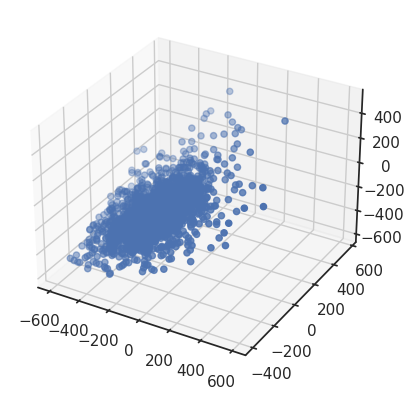

In [70]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*train_data[targets].sample(frac=0.1).values.T)

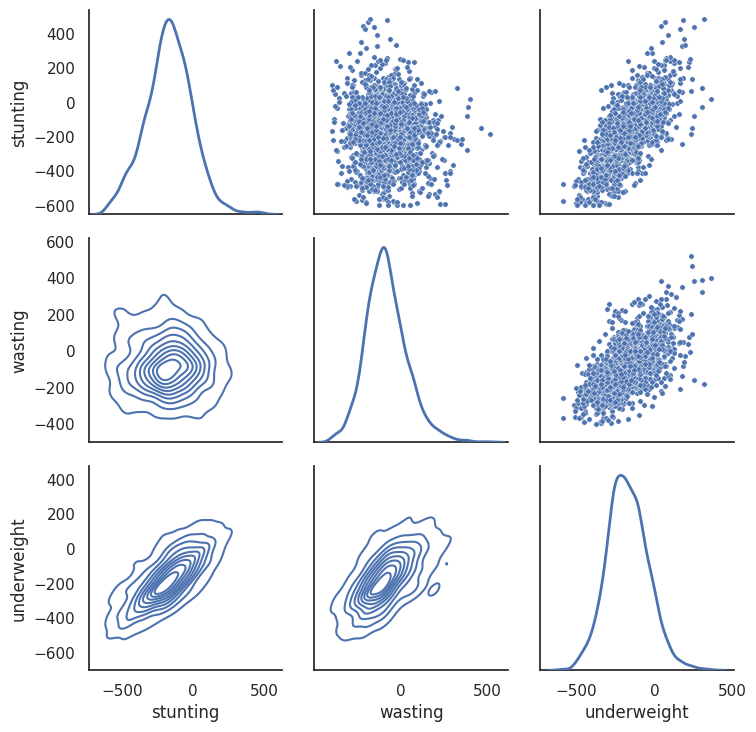

In [71]:
sns.set_theme(style="white")

g = sns.PairGrid(train_data[targets].sample(frac=0.1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

In [72]:
from sklearn.preprocessing import StandardScaler

In [75]:
scaler=StandardScaler()

In [102]:
train_scaled=scaler.fit_transform(train_data)
val_scaled=scaler.transform(val_data)
test_scaled=scaler.transform(test_data)

In [103]:
train_scaled.shape

(19671, 43)

In [104]:
x_train, y_train = torch.as_tensor(train_scaled[..., :-3]), torch.as_tensor(train_scaled[..., -3:])

## Univariate

In [105]:
x_train.shape, y_train.shape

(torch.Size([19671, 40]), torch.Size([19671, 3]))

In [106]:
set_seed(1)
dims = len(targets)
dist_x = torch.distributions.Independent(
    torch.distributions.Normal(torch.zeros(dims), torch.ones(dims)), 1
)

bijector = B.Compose(
    [
        # B.Affine(),
        BernsteinPolynomial(
            order=30,
            thetas_constraint_fn=enshure_ordered_scaled(
                low=-4,
                high=4,
                constrain_second_drivative="zero",
            ),
            context_shape=[None, x_train.shape[-1]],
            extrapolation="linear",
        ),
        B.Affine(),
    ]
)
dist_y = D.Flow(dist_x, bijector)

In [ ]:
optimizer = torch.optim.Adam(dist_y.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=50, verbose=True
)
grads = []
for step in range(5001):
    optimizer.zero_grad()

    loss = -dist_y.log_prob(value=y_train, context=None).mean()
    loss.backward()

    optimizer.step()
    scheduler.step(loss.detach())

    #grads.append(dist_y.bijector.bijectors[0]._params_fn.params[0].grad.numpy().copy())

    if step % 200 == 0:
        print("step: {}, loss: {}".format(step, loss.item()))

step: 0, loss: 14.227182454041962
step: 200, loss: 4.229304983427575


In [90]:
g = np.stack(grads, 0)

ValueError: need at least one array to stack

In [ ]:
g.shape

In [ ]:
fig = plt.plot(g[:, 1], label=[f"$\\vartheta_{{{i}}}$" for i in range(g.shape[-1])])
# plt.legend()

In [ ]:
x = torch.linspace(-2, 2, 200)
xx = torch.stack((x, x), 1)
y = dist_y.bijector.inverse(xx).detach()
x_inv = dist_y.bijector.forward(y).detach()
plt.plot(xx, y, x_inv, y, ":")
torch.mean((xx - x_inv) ** 2)

In [ ]:
p = torch.exp(dist_y.log_prob(torch.stack((x, x), 1))).detach()
p.shape
plt.plot(x, p)

In [ ]:
x = torch.linspace(-2, 2, 200)
y = dist_y.bijector.inverse(xx).detach()  # type: ignore
ladj = -dist_y.bijector.log_abs_det_jacobian(y, xx).detach()  # type: ignore
log_prob = ladj + dist_x.log_prob(xx)[..., None]
prob = torch.exp(log_prob).detach()
plt.plot(xx, y, xx, ladj)

In [ ]:
plot_samples(dist_y, train_data=X)

In [ ]:
dist_y.bijector.bijectors[0]._params_fn.params[0]

## Multiivariateparameters

In [ ]:
set_seed(1)
dist_x = torch.distributions.Independent(
    torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 1
)
bijector = B.Compose(
    [
        BernsteinPolynomialAutoregressive(
            params_fn=P.DenseAutoregressive(hidden_dims=(16,32)),
            order=200,
            thetas_constraint_fn=enshure_ordered_scaled(
                low=-5,
                high=5,
                constrain_second_drivative="zero",
                #fn=torch.abs
            ),
            extrapolation="linear",
        ),
        B.Affine(),
    ]
)
dist_y = D.Flow(dist_x, bijector)

In [ ]:
optimizer = torch.optim.Adam(dist_y.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=100, verbose=True
)
# grads=[]
for step in range(5001):
    optimizer.zero_grad()

    loss = -dist_y.log_prob(X).mean()
    loss.backward()

    optimizer.step()
    scheduler.step(loss.detach())

    # grads.append(dist_y.bijector.bijectors[0]._params_fn.params[0].grad.numpy().copy())

    if step % 200 == 0:
        print("step: {}, loss: {}".format(step, loss.item()))

In [ ]:
plot_samples(dist_y, train_data=X)

In [ ]:
dist_y.bijector.bijectors

In [ ]:
params,=dist_y.bijector.bijectors[0]._params_fn(torch.tensor([0.,0.]))
params.shape

In [ ]:
dist_y.bijector.bijectors[1]._params_fn()

In [ ]:
thetas_constraint_fn=enshure_ordered_scaled(
                low=-5,
                high=5,
                constrain_second_drivative="zero",
                #fn=torch.abs
            )

In [ ]:
thetas=thetas_constraint_fn(params)

In [ ]:
b_poly = gen_bernstein_polynomial_with_linear_extrapolation(thetas)